# Colab routines

In [1]:
!pip3 install torch

In [2]:
!git clone https://github.com/annafumagalli/LISA-M-project.git

fatal: destination path 'LISA-M-project' already exists and is not an empty directory.


In [3]:
cd ./LISA-M-project

/content/LISA-M-project


---------------------------------

In [1]:
import sys
sys.path.insert(0, '/home/annaf/LDC_project/masters_project/lib/python3.6/site-packages')

In [2]:
%matplotlib inline
import numpy as np
import scipy
from scipy.stats.stats import pearsonr
from scipy.signal import chirp
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchsummary import summary

from CDAE_model import *
from CDAE_training import *
import MBH_phenomD as mbhb_ph

import copy
import random
import cv2

/home/annaf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Testing the trained models

In [4]:
# Fixed dataset parameters

n = 1000      # number of training sets per batch
T = 60*10     # 10 min of data, sampled every 0.1 s
fs = 10       # sampling frequency
N = T*fs
t = np.linspace(0,T,N)

# FFT parameters

NFFT = 20*fs   # FTT time interval
NOVL = NFFT*0.71      # overlap
window = np.blackman(NFFT) 

In [5]:
def normalise(x):
    y = (x - x.min())/(x.max() - x.min())
    return y

In [6]:
# Plots ranges, LISA freqs and time

extent = [0, 30, 1e-5, 1e0]    # 0-30 days, 1e-5-1 Hz

In [7]:
# Load trained nets

s_net = torch.load('./saved_models/s_net_14-02-2019_17:55:15.pt')
#sg_net = torch.load('./saved_models/sg_net_12-02-2019_17:30:49.pt')
chirp_net = torch.load('./saved_models/chirp_net_14-02-2019_18:58:00.pt')
ms_net = torch.load('./saved_models/ms_net_14-02-2019_19:55:00.pt')
tchirp_net = torch.load('./saved_models/tchirp_net_14-02-2019_19:26:29.pt')
mbhb_net = torch.load('./saved_models/mbhb_net_26-02-2019_14:42:45.pt')

/home/annaf/anaconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'CDAE_model.CDAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# 3 sines + 1 chirp

In [8]:
# Signals - the sine waves have different amplitude

ts_sine1 = 3.0*np.sin(2*np.pi*1.0*t)
ts_sine2 = 3.5*np.sin(2*np.pi*2.0*t)
ts_sine3 = 4.0*np.sin(2*np.pi*3.0*t)

k1 = (2.0/0.5)**(1/350.0)
ts_chirp1 = 5.0*np.sin(1.0*np.pi*0.5*((k1**t-1)/np.log(k1)))
k2 = (3.7/0.5)**(1/900.0)
ts_chirp2 = 4.0*np.sin(5.0*np.pi*0.5*((k2**t-1)/np.log(k2)))

# Spectrograms

spec_sines,_,_ = plt.mlab.specgram((ts_sine1+ts_sine2+ts_sine3), NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
spec_sines = spec_sines[:100,:100]
spec_chirp,_,_ = plt.mlab.specgram((ts_chirp1+ts_chirp2), NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
spec_chirp = spec_chirp[:100,:100]

# MIX 1: Sine + sine gaussian

mix1 = spec_sines + spec_chirp

# Format for net input and comparisons (100x100)

mix1 = normalise(mix1)
spec_sines = normalise(spec_sines)
spec_chirp = normalise(spec_chirp)


spec_size=(mix1.shape[0], mix1.shape[1])

print(spec_size)

mix1 = Variable(torch.from_numpy(mix1)).to(device)
mix1 = mix1.reshape(1,1,spec_size[0],spec_size[1])
mix1 = mix1.type(torch.cuda.FloatTensor)

(100, 100)


In [9]:
# Apply trained models

chirp_test_out = chirp_net(mix1)
s_test_out = s_net(mix1)

chirp_test_out = chirp_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()
s_test_out = s_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()

In [10]:
# Calculate overalp scores --- i.e. correlation coeffiecients

chirp_score,_ = scipy.stats.pearsonr(chirp_test_out.flat, spec_chirp.flat)
s_score,_ = scipy.stats.pearsonr(s_test_out.flat, spec_sines.flat)

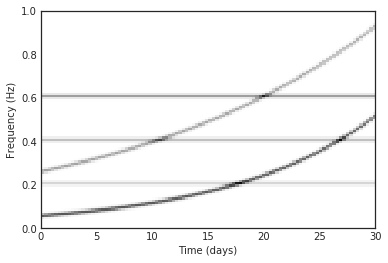

In [11]:
# Plot results

#%matplotlib notebook
#%matplotlib notebook  
#import matplotlib.pyplot as plt

plt.imshow(mix1.reshape(spec_size[0],spec_size[1]).cpu().numpy(),aspect='auto', origin='lower', extent=extent)
#plt.title('Mixed input')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()

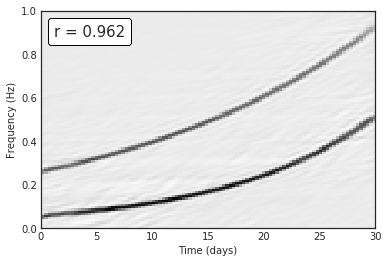

overlap score: 0.9621239297866746


In [12]:
from matplotlib.offsetbox import AnchoredText
at = AnchoredText("r = "+str(round(chirp_score,3)),
                  prop=dict(size=15), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

fig, ax = plt.subplots() 

im = ax.imshow(chirp_test_out,aspect='auto', origin='lower', extent=extent)
#ax.set_title('Chirp-net output')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Frequency (Hz)')
ax.add_artist(at)
plt.show()

print('overlap score:',chirp_score)

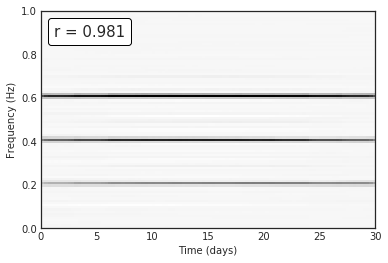

overlap score: 0.9814733201621639


In [13]:
at = AnchoredText("r = "+str(round(s_score,3)),
                  prop=dict(size=15), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

fig, ax = plt.subplots() 

im = ax.imshow(s_test_out,aspect='auto', origin='lower', extent=extent)
#ax.set_title('Sine-net output')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Frequency (Hz)')
ax.add_artist(at)
plt.show()

print('overlap score:', s_score)

## Truncated chirp + frequency modulated sine

In [14]:
# Signals

ts_ms1 = 1.0*np.sin(2*np.pi*1.5*t + + 55.0*np.sin(2*np.pi*20.0*t))
ts_ms2 = 1.0*np.sin(2*np.pi*3.5*t + + 150.0*np.sin(2*np.pi*20.0*t))

k1 = (2.5/0.5)**(1/250.0)
ts_tchirp1 = 1.5*np.sin(2.0*np.pi*0.2*((k1**t[:4600]-1)/np.log(k1)))
ts_tchirp1 = np.append(ts_tchirp1, np.zeros(1400))
#k2 = (2.5/1.3)**(1/250.0)
#ts_tchirp2 = 1.5*np.sin(2.0*np.pi*0.2*((k2**t-1)/np.log(k2)))
#ts_tchirp2 = np.append(ts_tchirp2, np.zeros(1400))

# Spectrograms

spec_ms,_,_ = plt.mlab.specgram((ts_ms1+ts_ms2), NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
spec_ms = spec_ms[:100,:100]
spec_tchirp,_,_ = plt.mlab.specgram(ts_tchirp1, NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
spec_tchirp = spec_tchirp[:100,:100]

# MIX 2: Truncated chirp + frequency modulated sine

mix2 = spec_ms + spec_tchirp

# Format for net input (100x100)

mix2 = normalise(mix2)
spec_ms = normalise(spec_ms)
spec_tchirp = normalise(spec_tchirp)

mix2 = Variable(torch.from_numpy(mix2)).to(device)
mix2 = mix2.reshape(1,1,spec_size[0],spec_size[1])
mix2 = mix2.type(torch.cuda.FloatTensor)

mix2.size()

torch.Size([1, 1, 100, 100])

In [15]:
# Apply trained models

tchirp_test_out = tchirp_net(mix2)
ms_test_out = ms_net(mix2)

tchirp_test_out = tchirp_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()
ms_test_out = ms_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()

In [16]:
# Calculate overalp scores --- i.e. correlation coeffiecients

tchirp_score,_ = scipy.stats.pearsonr(tchirp_test_out.flat, spec_tchirp.flat)
ms_score,_ = scipy.stats.pearsonr(ms_test_out.flat, spec_ms.flat)

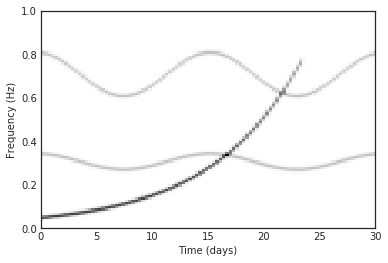

In [17]:
# Plot results

plt.imshow(mix2.reshape(spec_size[0],spec_size[1]).cpu().numpy(),aspect='auto', origin='lower', extent=extent)
#plt.title('Mixed input')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()

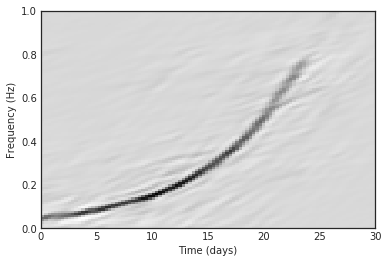

overlap score: 0.8615848504518063


In [18]:
plt.imshow(tchirp_test_out,aspect='auto', origin='lower', extent=extent)
#plt.title('Cleaned chirp output')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()

print('overlap score:', tchirp_score)

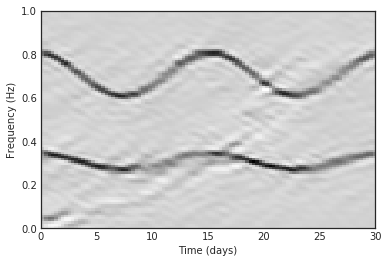

overlap score: 0.8294836592887652


In [19]:
plt.imshow(ms_test_out,aspect='auto', origin='lower', extent=extent)
#plt.title('Cleaned sine output')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()

print('overlap score:', ms_score)

## MBHB and frequency modulated sines

In [25]:
# To create MBHB spectrograms will define new (longer) time vector

#Define the time range
dt = 20.0
Tobs = 15*24*3600  # 2 weeks of data, cadence 20 seconds
Nbh = int(Tobs/dt)   # number of data point = 64800

tvec = np.arange(Nbh)*dt

# Define the generation of templates
theta = []

theta.append(0.5)            #[0] 'beta' - EclipticLatitude
theta.append(1.2)            #[1] 'lambda' - EclipticLongitude
theta.append(3000.0)         #[2] 'mc' - chirp mass
theta.append(1.5)            #[3] 'q' - mass ratio
theta.append(0.91)           #[4] 'chi1' - magnitude Spin1 [-1,1]
theta.append(0.9)            #[5] 'chi2' - magnitude Spin2 [-1,1]
theta.append(13*24*3600)     #[6] 'Tc' - CoalescenceTime

# Time Series

mbh = mbhb_ph.MBHB_phenomD(theta)
freq, Af, Ef = mbh.TDI_signal(tvec)
tm, ts_mbhb = mbhb_ph.ComputeTD(Af,dt)

# FFT parameters

NFFT1 = 1000 #FTT time interval
NOVL1 = NFFT1*0.88     # overlap
window1 = np.blackman(NFFT1) 

# Spectrograms

spec_mbhb, _, _ = plt.mlab.specgram(ts_mbhb, NFFT=NFFT1, Fs=1/dt, window=window1, noverlap=NOVL1)
spec_mbhb = cv2.resize(spec_mbhb, dsize=(100, 100))
spec_mbhb = normalise(spec_mbhb)
spec_mbhb = np.array(spec_mbhb) 

# MIX 3: MBHB + frequency modulated sines

mix3 = spec_ms + spec_mbhb

# Format for net input (100x100)

mix3 = normalise(mix3)

mix3 = Variable(torch.from_numpy(mix3)).to(device)
mix3 = mix3.reshape(1,1,spec_size[0],spec_size[1])
mix3 = mix3.type(torch.cuda.FloatTensor)

mix3.size()

torch.Size([1, 1, 100, 100])

In [26]:
# Apply trained models

mbhb_test_out = mbhb_net(mix3)
ms_test_out = ms_net(mix3)

mbhb_test_out = mbhb_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()
ms_test_out = ms_test_out.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()

In [27]:
# Calculate overalp scores --- i.e. correlation coeffiecients

mbhb_score,_ = scipy.stats.pearsonr(mbhb_test_out.flat, spec_mbhb.flat)
ms_score,_ = scipy.stats.pearsonr(ms_test_out.flat, spec_ms.flat)

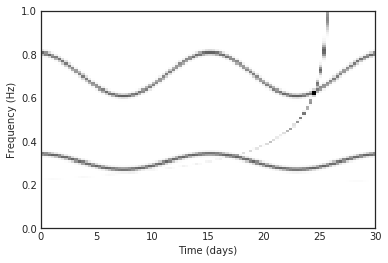

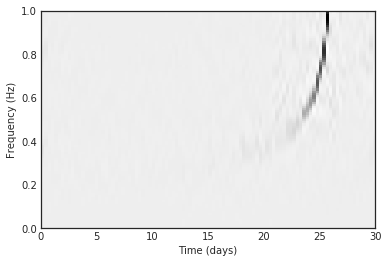

overlap score: 0.7571925131531967


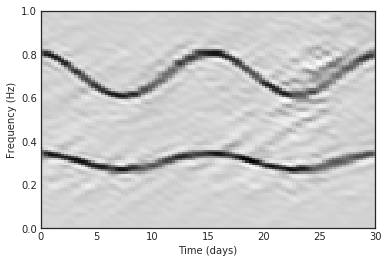

overlap score: 0.8387482176693639


In [28]:
# Plot results

plt.imshow(mix3.reshape(spec_size[0],spec_size[1]).cpu().numpy(),aspect='auto', origin='lower', extent=extent)
#plt.title('Mixed input')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.imshow(mbhb_test_out,aspect='auto', origin='lower', extent=extent)
#plt.title('Cleaned chirp output')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()

print('overlap score:', mbhb_score)

plt.imshow(ms_test_out,aspect='auto', origin='lower', extent=extent)
#plt.title('Cleaned sine output')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()

print('overlap score:', ms_score)

# Testing performance with noise

Want to test model performance with decreasing SNR. Compute correlation coeffience for 10 datasets with progressively decreasing signal amplitude and fixed gaussian noise. Table/graph results. For this analysis only sine-chirp mixs are used.

In [24]:
# Load trained nets

noisy_s_net = torch.load('./saved_models/noisy_sine_net_26-02-2019_12:05:21.pt')
noisy_chirp_net = torch.load('./saved_models/noisy_chirp_net_26-02-2019_12:38:36.pt')

In [25]:
def SNR(amp, noise):
    snr = (amp/noise)*(1/np.sqrt(2))#*np.sqrt(N)? signal amplitude over noise standard deviation
    return snr

# Array of amplitudes to test
amp = np.array([0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 5.0, 10.0])
snr = SNR(amp, 0.7) 

snr

array([ 0.        ,  0.40406102,  0.80812204,  1.21218305,  1.61624407,
        2.02030509,  2.42436611,  2.82842712,  5.05076272, 10.10152545])

In [26]:
# Time series

ts_noisy_sines = np.zeros((10,N))
ts_noisy_chirp = np.zeros((10,N))
for i in range(10):
    ts_noisy_sines[i,:] = amp[i]*(np.sin(2*np.pi*1.0*t)+np.sin(2*np.pi*2.0*t)
                            +np.sin(2*np.pi*3.0*t))+np.random.normal(0.0, 0.7, N)
    k = (2.0/0.5)**(1/350.0)
    ts_noisy_chirp[i,:] = amp[i]*np.sin(2.0*np.pi*0.5*((k**t-1)/np.log(k)))+np.random.normal(0.0, 0.7, N)

# Spectrograms

noisy_spec_sines = []
noisy_spec_chirp = []
for i in range(10):
    
    temp1,_,_ = plt.mlab.specgram(ts_noisy_sines[i,:], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    noisy_spec_sines.append(temp1)
    
    temp1,_,_ = plt.mlab.specgram(ts_noisy_chirp[i,:], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    noisy_spec_chirp.append(temp1)

noisy_spec_chirp = np.array(noisy_spec_chirp)
noisy_spec_chirp = noisy_spec_chirp[:,:100,:100]
noisy_spec_sines = np.array(noisy_spec_sines)
noisy_spec_sines = noisy_spec_sines[:,:100,:100]

# NOISY MIX: noisy sines + noisy chirp

noisy_spec_mix = noisy_spec_chirp + noisy_spec_sines

# Format for net input (100x100)

noisy_spec_mix = normalise(noisy_spec_mix)
noisy_spec_chirp = normalise(noisy_spec_chirp)
noisy_spec_sines = normalise(noisy_spec_sines)


noisy_spec_mix = Variable(torch.from_numpy(noisy_spec_mix)).to(device)
noisy_spec_mix = noisy_spec_mix.reshape(1,1,10,spec_size[0],spec_size[1])
noisy_spec_mix = noisy_spec_mix.type(torch.cuda.FloatTensor)

In [27]:
# Apply trained models

chirp_test_out = []
s_test_out = []
for i in range(10):
    
    a = chirp_net(noisy_spec_mix[:,:,i])
    b = a.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()
    chirp_test_out = np.append(chirp_test_out, b)
    
    c = s_net(noisy_spec_mix[:,:,i])
    d = c.reshape(spec_size[0],spec_size[1]).detach().cpu().numpy()
    s_test_out = np.append(s_test_out, d)

chirp_test_out = chirp_test_out.reshape(10,spec_size[0],spec_size[1])
s_test_out = s_test_out.reshape(10,spec_size[0],spec_size[1])   

In [28]:
noisy_spec_sines[0].flatten().shape

(10000,)

In [29]:
# Calculate overalp scores --- i.e. correlation coeffiecients
# Problem: atm corr coeff are calculated against noisy targets, not sure if this is right

chirp_scores = []
s_scores = []
for i in range(10):
    temp,_ = scipy.stats.pearsonr(chirp_test_out[i].flat, noisy_spec_chirp[i].flat)
    chirp_scores.append(temp)
    
    temp1,_ = scipy.stats.pearsonr(s_test_out[i].flat, noisy_spec_sines[i].flat)
    s_scores.append(temp1)

<IPython.core.display.Javascript object>


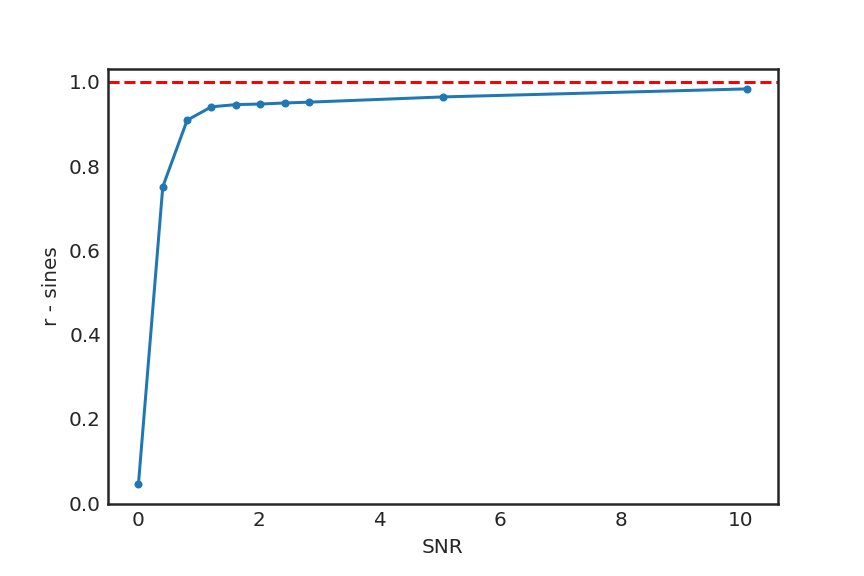

In [101]:
fig, ax = plt.subplots()

ax.plot(snr, s_scores, '.-')
ax.set_xlabel('SNR')
ax.set_ylabel('r - sines')
ax.axhline(y=1.0,xmin=0.0, xmax=1.0,color='r', linestyle='dashed')
plt.show()

<IPython.core.display.Javascript object>


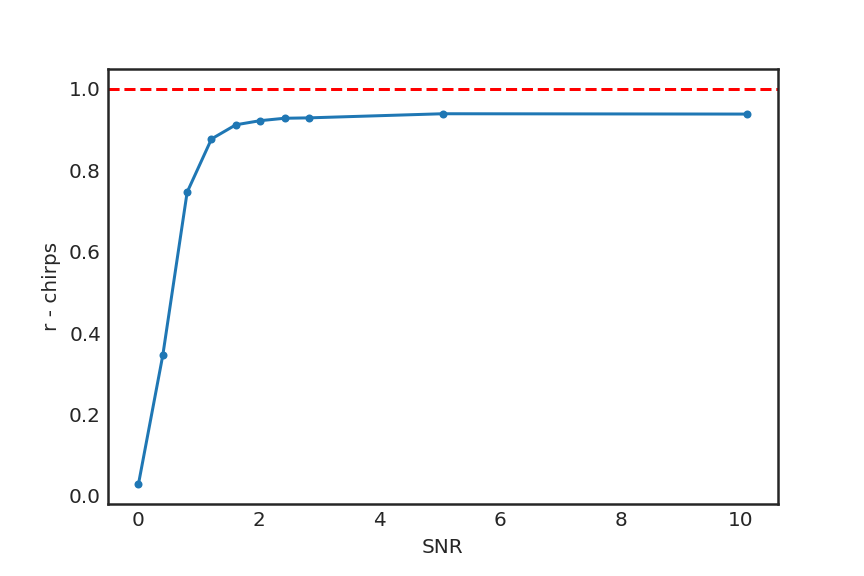

In [100]:
fig, ax = plt.subplots()

ax.plot(snr, chirp_scores, '.-')
ax.set_xlabel('SNR')
ax.set_ylabel('r - chirps')
ax.axhline(y=1.0,xmin=0.0, xmax=1.0,color='r', linestyle='dashed')
plt.show()

In [32]:
chirp_scores

[0.02870631423458101,
 0.345383613690326,
 0.746117063183792,
 0.8769878466632983,
 0.9117749832749091,
 0.9219360511635979,
 0.92783283105784,
 0.928798515302752,
 0.9389367599448201,
 0.9381116998654159]

<IPython.core.display.Javascript object>


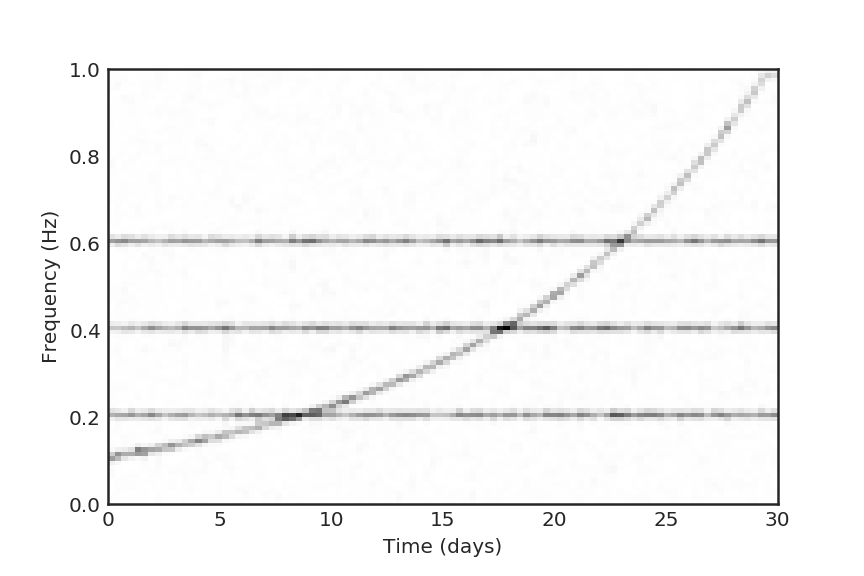

In [47]:
%matplotlib notebook
%matplotlib notebook  
import matplotlib.pyplot as plt


plt.imshow(noisy_spec_mix[:,:,3].reshape(spec_size[0],spec_size[1]).cpu().numpy(),aspect='auto', origin='lower', extent=extent)
#plt.title('Mixed input')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()


<IPython.core.display.Javascript object>


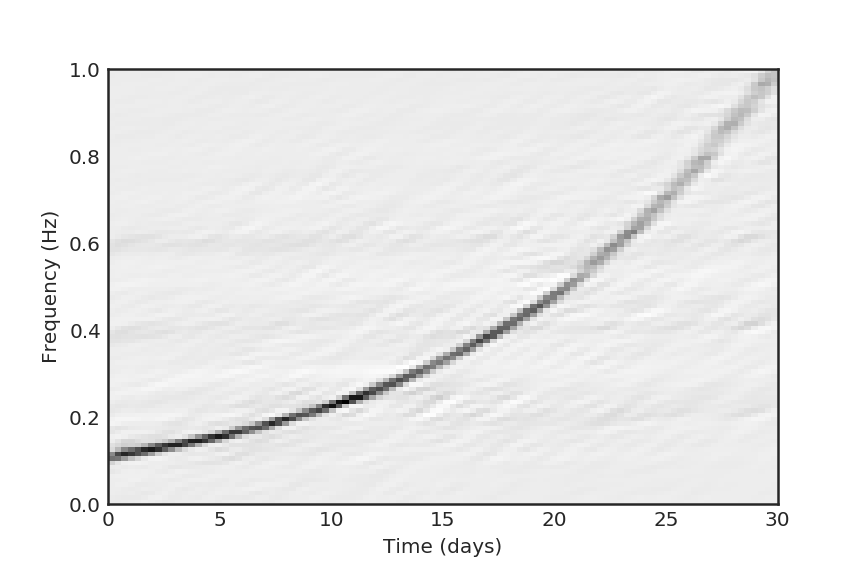

In [54]:
plt.imshow(chirp_test_out[3],aspect='auto', origin='lower', extent=extent)
#plt.title('Cleaned chirp output')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()


<IPython.core.display.Javascript object>


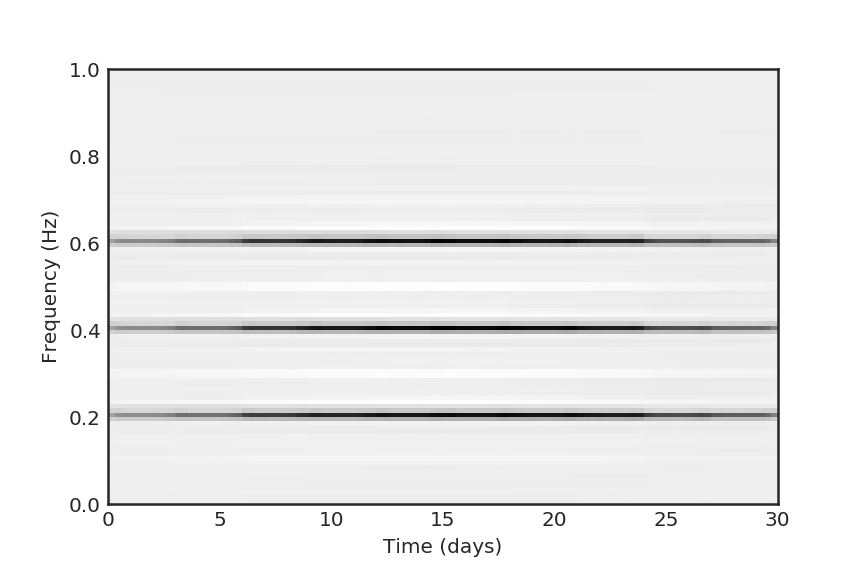

In [58]:
plt.imshow(s_test_out[3],aspect='auto', origin='lower', extent=extent)
#plt.title('Cleaned sine output')
plt.xlabel('Time (days)')
plt.ylabel('Frequency (Hz)')
plt.show()